In [1]:
import pandas as pd

# Read the CSV file into a DataFrame
column_names = ["text", "is_hate"]

df = pd.read_csv('1.preprocessed_data.csv', on_bad_lines='skip', sep=",", encoding='iso-8859-1', header=0, names=column_names)
df['is_hate'] = df['is_hate'].astype(bool)
df['text'] = df['text'].astype('str')
df.head()

,text,is_hate
0,ponnayo danne kellek aduwa gaman laga inna kol...,True
1,ape harak samjeta eka honda adrshyak,False
2,tpita pisuda yako man htuwe atta kiyala aiyo,False
3,kimbak eduwoth ape untath amma thaththawath pe...,True
4,lisan nathawa yanna puluwan yako api dannawa o...,False


In [2]:
#### Import necessary libraries

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### Data Preparation
# Splitting the data into train and test
train_texts, test_texts, train_labels, test_labels = train_test_split(df['text'], df['is_hate'], test_size=0.2, random_state=42)

# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

# Padding
# max_length = max([len(seq) for seq in train_sequences])
max_length = 18
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post')

vocab_size = len(tokenizer.word_index) + 1


# Build the CNN model

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

embedding_dim = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 18, 128)           881152    
                                                                 
 conv1d (Conv1D)             (None, 14, 128)           82048     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                        

In [4]:
# Train the model
model.fit(train_padded, train_labels, epochs=10, validation_data=(test_padded, test_labels))


Epoch 1/10
56/56 [==============================] - 1s 5ms/step - loss: 0.6781 - accuracy: 0.5947 - val_loss: 0.6696 - val_accuracy: 0.5918
Epoch 2/10
56/56 [==============================] - 0s 4ms/step - loss: 0.5706 - accuracy: 0.7279 - val_loss: 0.5100 - val_accuracy: 0.7687
Epoch 3/10
56/56 [==============================] - 0s 5ms/step - loss: 0.1919 - accuracy: 0.9450 - val_loss: 0.5233 - val_accuracy: 0.8027
Epoch 4/10
56/56 [==============================] - 0s 4ms/step - loss: 0.0465 - accuracy: 0.9887 - val_loss: 0.6198 - val_accuracy: 0.7868
Epoch 5/10
56/56 [==============================] - 0s 4ms/step - loss: 0.0198 - accuracy: 0.9949 - val_loss: 0.7172 - val_accuracy: 0.7823
Epoch 6/10
56/56 [==============================] - 0s 5ms/step - loss: 0.0076 - accuracy: 0.9983 - val_loss: 0.7848 - val_accuracy: 0.7823
Epoch 7/10
56/56 [==============================] - 0s 5ms/step - loss: 0.0040 - accuracy: 0.9994 - val_loss: 0.8717 - val_accuracy: 0.7891
Epoch 8/10
56/56 [==

In [5]:
## Evaluate the model
loss, accuracy = model.evaluate(test_padded, test_labels)
print(f"Model Accuracy: {accuracy * 100:.2f}%")


14/14 [==============================] - 0s 1ms/step - loss: 1.0550 - accuracy: 0.7868
Model Accuracy: 78.68%


In [12]:
from sklearn.metrics import classification_report

predictions = (model.predict(test_padded) > 0.5).astype('int32').flatten()
report = classification_report(test_labels, predictions)
print(report)


14/14 [==============================] - 0s 836us/step
              precision    recall  f1-score   support

       False       0.77      0.90      0.83       260
        True       0.81      0.62      0.71       181

    accuracy                           0.79       441
   macro avg       0.79      0.76      0.77       441
weighted avg       0.79      0.79      0.78       441



In [7]:
def preprocess_text(texts, tokenizer, max_length):
    sequences = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(sequences, maxlen=max_length, padding='post')
    return padded

new_texts = ["kalakanni deshapaluwo"]
new_padded = preprocess_text(new_texts, tokenizer, max_length)
predictions = model.predict(new_padded)
threshold = 0.5
predicted_labels = (predictions > threshold).astype(int)

for text, label in zip(new_texts, predicted_labels):
    print(f"Text: {text}")
    print(f"Predicted label: {'Hate' if label == 1 else 'Not Hate'}")



1/1 [==============================] - 0s 9ms/step
Text: kalakanni deshapaluwo
Predicted label: Hate


# Confusion Matrix:
A confusion matrix helps to understand the performance of the model in terms of true positives, true negatives, false positives, and false negatives.

14/14 [==============================] - 0s 1ms/step


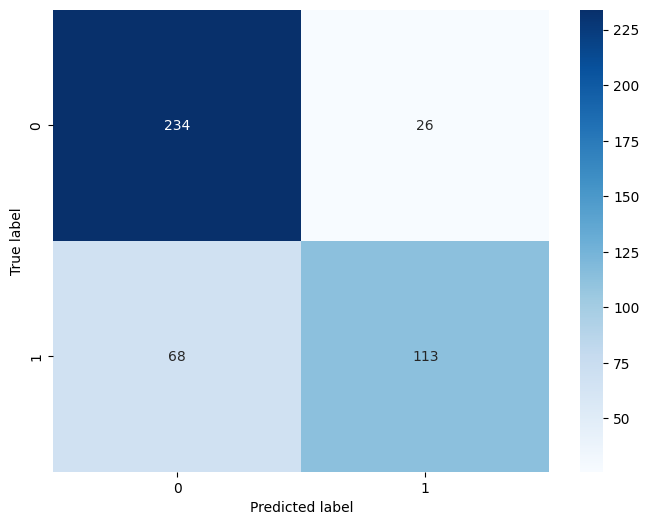

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

predictions = (model.predict(test_padded) > 0.5).astype('int32').flatten()
cm = confusion_matrix(test_labels, predictions)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # normalize the confusion matrix

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


# ROC Curve and AUC:
A Receiver Operating Characteristic (ROC) curve illustrates the performance of the binary classifier system. The Area Under the Curve (AUC) represents the model's capability to distinguish between the classes.

14/14 [==============================] - 0s 3ms/step


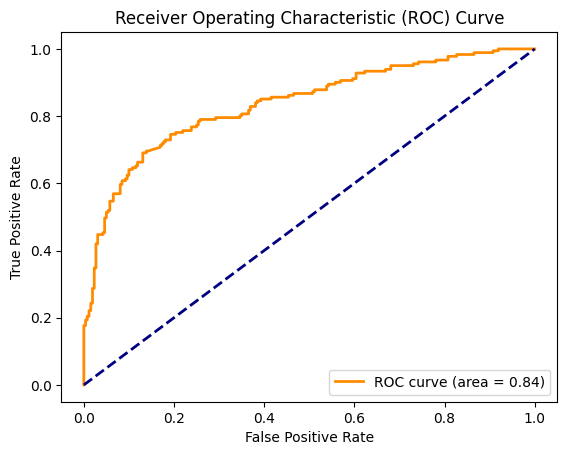

In [9]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(test_labels, model.predict(test_padded))
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [13]:
import pickle
# save the values to a file
with open('2.6 CNN.pkl', 'wb') as f:
    pickle.dump({
        'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc, 'cm_percentage': cm_percentage, 'report': report
    }, f)

Epoch 1/5
56/56 [==============================] - 0s 5ms/step - loss: 0.0060 - accuracy: 0.9989 - val_loss: 0.9163 - val_accuracy: 0.7778
Epoch 2/5
56/56 [==============================] - 0s 4ms/step - loss: 0.0041 - accuracy: 0.9989 - val_loss: 0.9144 - val_accuracy: 0.7710
Epoch 3/5
56/56 [==============================] - 0s 5ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.9947 - val_accuracy: 0.7687
Epoch 4/5
56/56 [==============================] - 0s 5ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.9962 - val_accuracy: 0.7755
Epoch 5/5
56/56 [==============================] - 0s 6ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 1.0463 - val_accuracy: 0.7710


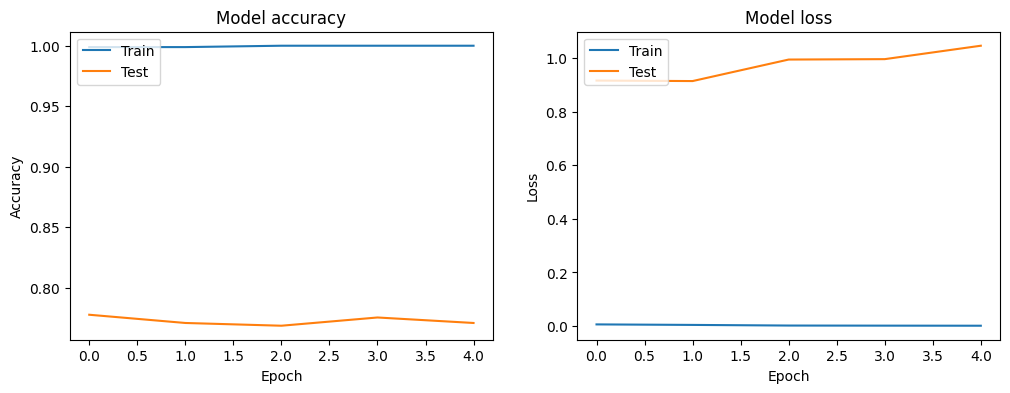

In [ ]:
history = model.fit(train_padded, train_labels, epochs=5, validation_data=(test_padded, test_labels))

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


### Model Interpretability:
You can use libraries like SHAP (SHapley Additive exPlanations) or LIME (Local Interpretable Model-agnostic Explanations) to understand which parts of the input text contributed most to the model's decision.

### Error Analysis:
Manually inspect cases where the model made mistakes. This can give insights into patterns the model is missing. By analyzing the false positives and false negatives, you can understand the model's specific weaknesses.

### Learning Rate Tuning:
Sometimes, adjusting the learning rate can help in improving the model's convergence. You can try out different learning rates or use learning rate schedulers.

### Cross-Validation:
Implement K-fold cross-validation to ensure that the model's performance is consistent across different subsets of the dataset.

Remember, model analysis and evaluation is iterative. Depending on what you find, you might return to previous steps, adjust the model architecture, gather more data, or attempt other techniques to refine the model.